In [2]:
import os
os.chdir('/Users/mcbookairdebat/Desktop/Projet/project/GitHub/Deep_hedging_research/Deep_Hedging/Deep_hedging_Hull/')
import gym
from gym import spaces
from gym.utils import seeding

import numpy as np

from utils import get_sim_path,compute_rewards
#from envs import  TradingEnv
import tensorflow as tf



from keras.models import Model
from keras.optimizers import Adam


from tensorflow.keras import backend as K
from tensorflow.keras.layers import (
    Input,
    Dense,
    Lambda,
    concatenate,
    BatchNormalization
)

import operator
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px




/Users/mcbookairdebat/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
class TradingEnv(gym.Env):
    """
    trading environment;
    """

    # trade_freq in unit of day, e.g 2: every 2 day; 0.5 twice a day;
    def __init__(self,num_sim=500002,
        continuous_action_flag=True, spread=0, init_ttm=20, trade_freq=1, num_contract=1,check_for_pretrained=False):

        # simulated data: array of asset price, option price and delta paths (num_path x num_period)
        # generate data now
        
        self.path, self.option_price_path, self.delta_path = get_sim_path(M=init_ttm, freq=trade_freq, num_sim=num_sim)
        # other attributes
        self.num_path = self.path.shape[0]

        # set num_period: initial time to maturity * daily trading freq + 1 (see get_sim_path() in utils.py)
        self.num_period = self.path.shape[1]
        # print("***", self.num_period)

        # time to maturity array
        self.ttm_array = np.arange(init_ttm, -trade_freq, -trade_freq)


        # spread
        self.spread = spread
        self.check_for_pretrained = check_for_pretrained
        # step function initialization depending on cash_flow_flag
        
        self.step = self.step_profit_loss

        self.num_contract = num_contract
        self.strike_price = 100

        # track the index of simulated path in use
        self.sim_episode = -1

        # track time step within an episode (it's step)
        self.t = None

        # action space
        if continuous_action_flag:
            self.action_space = spaces.Box(low=np.array([0]), high=np.array([num_contract]), dtype=np.float32)
        else:
            self.num_action = num_contract * 1 + 1
            self.action_space = spaces.Discrete(self.num_action)

        self.num_state = 3

        self.state = []

    def paths(self):
        return self.path,self.delta_path,self.option_price_path

   

    def reset(self):
        # repeatedly go through available simulated paths (if needed)
        self.sim_episode = (self.sim_episode + 1) % self.num_path
        self.t = 0

        price = self.path[self.sim_episode, self.t]
        position = self.delta_path[self.sim_episode,self.t]

        ttm = self.ttm_array[self.t]

        self.state = [price, position, ttm]

        return self.state

    def step_profit_loss(self, action):
        """
        profit loss period reward
        """

        # current prices (at t)
        current_price = self.state[0]
        current_option_price = self.option_price_path[self.sim_episode, self.t]

        # current position
        current_position = self.state[1]

        # update time
        self.t = self.t + 1
        # get state for tomorrow (at t + 1)
        price = self.path[self.sim_episode, self.t]
        option_price = self.option_price_path[self.sim_episode, self.t]
        position = action
        
        ttm = self.ttm_array[self.t]
        #print(price, position, ttm)
        self.state = [price, position, ttm]
        #print('state',self.state)

        # calculate period reward (part 1)
        reward = (price - current_price) * position/100 - np.abs(current_position - position) * current_price * self.spread/100

        # if tomorrow is end of episode
        if self.t == self.num_period-1:
            done = True
            reward = reward - (max(price - self.strike_price, 0) - current_option_price) * self.num_contract * 1 - position * price * self.spread/100
        else:
            done = False
            reward = reward - (option_price - current_option_price) * self.num_contract * 1

        # for other info later
        info = {"path_row": self.sim_episode}

        return self.state, reward, done, info

In [4]:
class ReplayBuffer(object):
    def __init__(self, size):
        """Create Replay buffer.

        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.
        """
        self._storage = []
        self._maxsize = size
        self._next_idx = 0

    def __len__(self):
        return len(self._storage)

    def add(self, obs_t, action, reward, obs_tp1, done):
        data = (obs_t, action, reward, obs_tp1, done)

        if self._next_idx >= len(self._storage):
            self._storage.append(data)
        else:
            self._storage[self._next_idx] = data
        self._next_idx = (self._next_idx + 1) % self._maxsize

    def _encode_sample(self, idxes):
        obses_t, actions, rewards, obses_tp1, dones = [], [], [], [], []
        for i in idxes:
            data = self._storage[i]

            obs_t, action, reward, obs_tp1, done = data
            obses_t.append(np.array(obs_t, copy=False))
            actions.append(np.array(action, copy=False))
            rewards.append(reward)
            obses_tp1.append(np.array(obs_tp1, copy=False))
            dones.append(done)
        return np.array(obses_t), np.array(actions), np.array(rewards), np.array(obses_tp1), np.array(dones)

    def sample(self, batch_size):
        """Sample a batch of experiences.

        Parameters
        ----------
        batch_size: int
            How many transitions to sample.

        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        """
        idxes = [np.random.randint(0, len(self._storage) - 1) for _ in range(batch_size)]
        return self._encode_sample(idxes)


class PrioritizedReplayBuffer(ReplayBuffer):
    def __init__(self, size, alpha):
        """Create Prioritized Replay buffer.

        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.
        alpha: float
            how much prioritization is used
            (0 - no prioritization, 1 - full prioritization)

        See Also
        --------
        ReplayBuffer.__init__
        """
        super(PrioritizedReplayBuffer, self).__init__(size)
        assert alpha >= 0
        self._alpha = alpha

        it_capacity = 1
        while it_capacity < size:
            it_capacity *= 2

        self._it_sum = SumSegmentTree(it_capacity)
        self._it_min = MinSegmentTree(it_capacity)
        self._max_priority = 1.0

    def add(self, *args, **kwargs):
        """See ReplayBuffer.store_effect"""
        idx = self._next_idx
        super().add(*args, **kwargs)
        self._it_sum[idx] = self._max_priority ** self._alpha
        self._it_min[idx] = self._max_priority ** self._alpha

    def _sample_proportional(self, batch_size):
        res = []
        p_total = self._it_sum.sum(0, len(self._storage) - 1)
        every_range_len = p_total / batch_size
        for i in range(batch_size):
            mass = np.random.random() * every_range_len + i * every_range_len
            idx = self._it_sum.find_prefixsum_idx(mass)
            res.append(idx)
        return res

    def sample(self, batch_size, beta):
        """Sample a batch of experiences.

        compared to ReplayBuffer.sample
        it also returns importance weights and idxes
        of sampled experiences.


        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        beta: float
            To what degree to use importance weights
            (0 - no corrections, 1 - full correction)

        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        weights: np.array
            Array of shape (batch_size,) and dtype np.float32
            denoting importance weight of each sampled transition
        idxes: np.array
            Array of shape (batch_size,) and dtype np.int32
            idexes in buffer of sampled experiences
        """
        assert beta > 0

        idxes = self._sample_proportional(batch_size)

        weights = []
        p_min = self._it_min.min() / self._it_sum.sum()
        max_weight = (p_min * len(self._storage)) ** (-beta)

        for idx in idxes:
            p_sample = self._it_sum[idx] / self._it_sum.sum()
            weight = (p_sample * len(self._storage)) ** (-beta)
            weights.append(weight / max_weight)
        weights = np.array(weights)
        encoded_sample = self._encode_sample(idxes)
        return tuple(list(encoded_sample) + [weights, idxes])

    def update_priorities(self, idxes, priorities):
        """Update priorities of sampled transitions.

        sets priority of transition at index idxes[i] in buffer
        to priorities[i].

        Parameters
        ----------
        idxes: [int]
            List of idxes of sampled transitions
        priorities: [float]
            List of updated priorities corresponding to
            transitions at the sampled idxes denoted by
            variable `idxes`.
        """
        assert len(idxes) == len(priorities)
        for idx, priority in zip(idxes, priorities):
            assert priority > 0
            assert 0 <= idx < len(self._storage)
            self._it_sum[idx] = priority ** self._alpha
            self._it_min[idx] = priority ** self._alpha

            self._max_priority = max(self._max_priority, priority)

class Schedule(object):
    def value(self, t):
        """Value of the schedule at time t"""
        raise NotImplementedError()


class ConstantSchedule(object):
    def __init__(self, value):
        """Value remains constant over time.

        Parameters
        ----------
        value: float
            Constant value of the schedule
        """
        self._v = value

    def value(self, t):
        """See Schedule.value"""
        return self._v


def linear_interpolation(l, r, alpha):
    return l + alpha * (r - l)


class PiecewiseSchedule(object):
    def __init__(self, endpoints, interpolation=linear_interpolation, outside_value=None):
        """Piecewise schedule.

        endpoints: [(int, int)]
            list of pairs `(time, value)` meanining that schedule should output
            `value` when `t==time`. All the values for time must be sorted in
            an increasing order. When t is between two times, e.g. `(time_a, value_a)`
            and `(time_b, value_b)`, such that `time_a <= t < time_b` then value outputs
            `interpolation(value_a, value_b, alpha)` where alpha is a fraction of
            time passed between `time_a` and `time_b` for time `t`.
        interpolation: lambda float, float, float: float
            a function that takes value to the left and to the right of t according
            to the `endpoints`. Alpha is the fraction of distance from left endpoint to
            right endpoint that t has covered. See linear_interpolation for example.
        outside_value: float
            if the value is requested outside of all the intervals sepecified in
            `endpoints` this value is returned. If None then AssertionError is
            raised when outside value is requested.
        """
        idxes = [e[0] for e in endpoints]
        assert idxes == sorted(idxes)
        self._interpolation = interpolation
        self._outside_value = outside_value
        self._endpoints = endpoints

    def value(self, t):
        """See Schedule.value"""
        for (l_t, l), (r_t, r) in zip(self._endpoints[:-1], self._endpoints[1:]):
            if l_t <= t and t < r_t:
                alpha = float(t - l_t) / (r_t - l_t)
                return self._interpolation(l, r, alpha)

        # t does not belong to any of the pieces, so doom.
        assert self._outside_value is not None
        return self._outside_value


class LinearSchedule(object):
    def __init__(self, schedule_timesteps, final_p, initial_p=1.0):
        """Linear interpolation between initial_p and final_p over
        schedule_timesteps. After this many timesteps pass final_p is
        returned.

        Parameters
        ----------
        schedule_timesteps: int
            Number of timesteps for which to linearly anneal initial_p
            to final_p
        initial_p: float
            initial output value
        final_p: float
            final output value
        """
        self.schedule_timesteps = schedule_timesteps
        self.final_p = final_p
        self.initial_p = initial_p

    def value(self, t):
        """See Schedule.value"""
        fraction = min(float(t) / self.schedule_timesteps, 1.0)
        return self.initial_p + fraction * (self.final_p - self.initial_p)

class SegmentTree(object):
    def __init__(self, capacity, operation, neutral_element):
        """Build a Segment Tree data structure.

        https://en.wikipedia.org/wiki/Segment_tree

        Can be used as regular array, but with two
        important differences:

            a) setting item's value is slightly slower.
               It is O(lg capacity) instead of O(1).
            b) user has access to an efficient ( O(log segment size) )
               `reduce` operation which reduces `operation` over
               a contiguous subsequence of items in the array.

        Paramters
        ---------
        capacity: int
            Total size of the array - must be a power of two.
        operation: lambda obj, obj -> obj
            and operation for combining elements (eg. sum, max)
            must form a mathematical group together with the set of
            possible values for array elements (i.e. be associative)
        neutral_element: obj
            neutral element for the operation above. eg. float('-inf')
            for max and 0 for sum.
        """
        assert capacity > 0 and capacity & (capacity - 1) == 0, "capacity must be positive and a power of 2."
        self._capacity = capacity
        self._value = [neutral_element for _ in range(2 * capacity)]
        self._operation = operation

    def _reduce_helper(self, start, end, node, node_start, node_end):
        if start == node_start and end == node_end:
            return self._value[node]
        mid = (node_start + node_end) // 2
        if end <= mid:
            return self._reduce_helper(start, end, 2 * node, node_start, mid)
        else:
            if mid + 1 <= start:
                return self._reduce_helper(start, end, 2 * node + 1, mid + 1, node_end)
            else:
                return self._operation(
                    self._reduce_helper(start, mid, 2 * node, node_start, mid),
                    self._reduce_helper(mid + 1, end, 2 * node + 1, mid + 1, node_end)
                )

    def reduce(self, start=0, end=None):
        """Returns result of applying `self.operation`
        to a contiguous subsequence of the array.

            self.operation(arr[start], operation(arr[start+1], operation(... arr[end])))

        Parameters
        ----------
        start: int
            beginning of the subsequence
        end: int
            end of the subsequences

        Returns
        -------
        reduced: obj
            result of reducing self.operation over the specified range of array elements.
        """
        if end is None:
            end = self._capacity
        if end < 0:
            end += self._capacity
        end -= 1
        return self._reduce_helper(start, end, 1, 0, self._capacity - 1)

    def __setitem__(self, idx, val):
        # index of the leaf
        idx += self._capacity
        self._value[idx] = val
        idx //= 2
        while idx >= 1:
            self._value[idx] = self._operation(
                self._value[2 * idx],
                self._value[2 * idx + 1]
            )
            idx //= 2

    def __getitem__(self, idx):
        assert 0 <= idx < self._capacity
        return self._value[self._capacity + idx]


class SumSegmentTree(SegmentTree):
    def __init__(self, capacity):
        super(SumSegmentTree, self).__init__(
            capacity=capacity,
            operation=operator.add,
            neutral_element=0.0
        )

    def sum(self, start=0, end=None):
        """Returns arr[start] + ... + arr[end]"""
        return super(SumSegmentTree, self).reduce(start, end)

    def find_prefixsum_idx(self, prefixsum):
        """Find the highest index `i` in the array such that
            sum(arr[0] + arr[1] + ... + arr[i - i]) <= prefixsum

        if array values are probabilities, this function
        allows to sample indexes according to the discrete
        probability efficiently.

        Parameters
        ----------
        perfixsum: float
            upperbound on the sum of array prefix

        Returns
        -------
        idx: int
            highest index satisfying the prefixsum constraint
        """
        assert 0 <= prefixsum <= self.sum() + 1e-5
        idx = 1
        while idx < self._capacity:  # while non-leaf
            if self._value[2 * idx] > prefixsum:
                idx = 2 * idx
            else:
                prefixsum -= self._value[2 * idx]
                idx = 2 * idx + 1
        return idx - self._capacity


class MinSegmentTree(SegmentTree):
    def __init__(self, capacity):
        super(MinSegmentTree, self).__init__(
            capacity=capacity,
            operation=min,
            neutral_element=float('inf')
        )

    def min(self, start=0, end=None):
        """Returns min(arr[start], ...,  arr[end])"""

        return super(MinSegmentTree, self).reduce(start, end)


In [5]:
class DRL:
    def __init__(self):
        if not os.path.exists('model'):
            os.mkdir('model')

        if not os.path.exists('history'):
            os.mkdir('history')

    def test(self, total_episode, delta_flag=False):
        """hedge with model.
        """
        print('testing...')

        self.epsilon = -1
        w_T_store = []
        actions =[]
        Y_0 =[]
        rewards =[]
        deltas, stock_prices, option_prices,w_T_means,w_T_vars  = [],[],[],[],[]
        for i in range(total_episode):
            action_store = []
            observation = self.env.reset()
            done = False
            reward_store = []
            while not done:
                # prepare state
                try:
                    x = np.array(observation).reshape(1, -1)
                except:
                    observation = [observation[0],observation[1][0], observation[2]]
                    x = np.array(observation).reshape(1, -1)

                if delta_flag:
                    action= self.env.delta_path[i % self.env.num_path, self.env.t] * self.env.num_contract * 1
                else:
                    # choose action from epsilon-greedy; epsilon has been set to -1
                    action, _, _ = self.egreedy_action(x)
                    action[0] =action[0]/100
                # store action to take a look

                try:
                    action_store.append(action[0])
                except:
                    action_store.append(action)
                observation, reward, done, info = self.env.step(action)

                try:
                    reward_store.extend(reward)
                except:
                    reward_store.append(reward)



            # get final wealth at the end of episode, and store it.
            w_T = sum(reward_store)
            w_T_store.append(w_T)
            actions.append(action_store)
            
            w_T_mean = np.mean(w_T_store)
            w_T_var = np.var(w_T_store)
            path_row = info["path_row"]
            #print(path_row)
            #print(info)
            '''with np.printoptions(precision=2, suppress=True):
                #print("episode: {} | final wealth: {:.2f}; so far mean and variance of final wealth was {} and {}".format(i, w_T, w_T_mean, w_T_var))
                print("episode: {} | so far Y(0): {:.2f}".format(i, -w_T_mean + self.ra_c * np.sqrt(w_T_var)))
                print("episode: {} | rewards: {}".format(i, np.array(reward_store)))
                print("episode: {} | action taken: {}".format(i, np.array(action_store)/100))
                print("episode: {} | deltas {}".format(i, self.env.delta_path[path_row]))
                print("episode: {} | stock price {}".format(i, self.env.path[path_row]))
                print("episode: {} | option price {}\n".format(i, self.env.option_price_path[path_row]))'''
            
            Y_0.append(-w_T_mean + self.ra_c * np.sqrt(w_T_var))
            rewards.append(reward_store)
            deltas.append(self.env.delta_path[path_row])
            stock_prices.append(self.env.path[path_row])
            option_prices.append(self.env.option_price_path[path_row])
            w_T_means.append(w_T_mean)
            w_T_vars.append(np.sqrt(w_T_var))

        #return {key: value for key, value in locals().items()}
        return w_T_store,Y_0,rewards,actions,deltas,stock_prices,option_prices,w_T_means,w_T_vars

    def plot(self, history):
        pass

    def save_history(self, history, name):
        name = os.path.join('history', name)

        df = pd.DataFrame.from_dict(history)
        df.to_csv(name, index=False, encoding='utf-8')

In [36]:
class DDPG(DRL):  # or DDPG(DRL) if you inherit from DRL
    """
    Deep Deterministic Policy Gradient - TF2 version
    """

    def __init__(self, env):
        super(DDPG, self).__init__()  # if you have a parent class DRL

        self.env = env
        self.upper_bound = self.env.action_space.high[0]
        self.lower_bound = self.env.action_space.low[0]

        # update rate for target model.
        self.TAU = 0.0001

        # learning rates
        self.actor_lr = 1e-4
        self.critic_lr = 1e-4

        # risk aversion constant
        self.ra_c = 1.5
        # Actor and Critic network

        self.actor = self._build_actor(learning_rate=self.actor_lr)
        self.critic_Q_ex, self.critic_Q_ex2, self.critic_Q = self._build_critic(learning_rate=self.critic_lr)
        # For debugging
        self.critic_Q.summary()

        # Target networks
        self.actor_hat = self._build_actor(learning_rate=self.actor_lr)
        self.actor_hat.set_weights(self.actor.get_weights())

        self.critic_Q_ex_hat, self.critic_Q_ex2_hat, self.critic_Q_hat = self._build_critic(learning_rate=self.critic_lr)
        self.critic_Q_ex_hat.set_weights(self.critic_Q_ex.get_weights())
        self.critic_Q_ex2_hat.set_weights(self.critic_Q_ex2.get_weights())

        # Epsilon-greedy
        self.epsilon = 1.0
        self.epsilon_decay = 0.99
        self.epsilon_min = 0.1

        # Replay buffer
        buffer_size = 600000
        prioritized_replay_alpha = 0.6
        self.replay_buffer = ReplayBuffer(buffer_size)
        prioritized_replay_beta0 = 0.4
        prioritized_replay_beta_iters = 50001
        self.beta_schedule = LinearSchedule(
            prioritized_replay_beta_iters,
            initial_p=prioritized_replay_beta0,
            final_p=1.0
        )
        self.prioritized_replay_eps = 1e-6

        # memory sample batch size
        self.batch_size = 128
        self.t = None

        # Optimizers
        self.actor_optimizer = Adam(self.actor_lr)
        self.critic_Q_ex_optimizer = Adam(self.critic_lr)
        self.critic_Q_ex2_optimizer = Adam(self.critic_lr)
        # The Q is a function of Q_ex and Q_ex2, so we won't train Q directly
        # with compile, we do it via the Q_ex, Q_ex2 fits or custom step.
        # But we keep a reference if you want to do a single-step approach.

    def load(self, tag=""):
        """Load weights from h5 files."""
        if tag == "":
            actor_file = "Deep_hedging_Hull/weights/ddpg_actor.weights.h5"
            critic_Q_ex_file = "Deep_hedging_Hull/weights/ddpg_critic_Q_ex.weights.h5"
            critic_Q_ex2_file = "Deep_hedging_Hull/weights/ddpg_critic_Q_ex2.weights.h5"
        else:
            actor_file = f"weights/bs/3month_daily/ddpg_actor_{tag}.h5"
            critic_Q_ex_file = f"weights/bs/3month_daily/ddpg_critic_Q_ex_{tag}.h5"
            critic_Q_ex2_file = f"weights/bs/3month_daily/ddpg_critic_Q_ex2_{tag}.h5"

            

        if os.path.exists(actor_file):
            self.actor.load_weights(actor_file)
            self.actor_hat.load_weights(actor_file)

            print(self.critic_Q2_ex)
        if os.path.exists(critic_Q_ex_file):
            self.critic_Q_ex.load_weights(critic_Q_ex_file)
            self.critic_Q_ex_hat.load_weights(critic_Q_ex_file)
            print(self.critic_Q_ex)
        if os.path.exists(critic_Q_ex2_file):
            self.critic_Q_ex2.load_weights(critic_Q_ex2_file)
            self.critic_Q_ex2_hat.load_weights(critic_Q_ex2_file)

    def _build_actor(self, learning_rate=1e-3):
        """Basic Actor NN."""
        inputs = Input(shape=(self.env.num_state,))
        x = BatchNormalization()(inputs)

        x = Dense(32, activation="relu")(x)
        x = BatchNormalization()(x)
        x = Dense(64, activation="relu")(x)
        x = BatchNormalization()(x)
        # Final output
        x = Dense(1, activation="sigmoid")(x)
        output = Lambda(lambda x: x * self.env.num_contract)(x)

        model = Model(inputs=inputs, outputs=output)
        model.compile(loss="mse", optimizer=Adam(learning_rate))
        return model

    def _build_critic(self, learning_rate=1e-3):
        """
        We build 2 critics, Q_ex and Q_ex2, and a derived Q = Q_ex - ra_c * sqrt(max(Q_ex2 - Q_ex^2, 0)).
        Note that Q_ex2 is the second moment, so Q_ex2 - Q_ex^2 is the variance, etc.
        """
        s_inputs = Input(shape=(self.env.num_state,))
        a_inputs = Input(shape=(1,))

        # combine
        x = concatenate([s_inputs, a_inputs])
        x = BatchNormalization()(x)

        # Q_ex
        x1 = Dense(32, activation="relu")(x)
        x1 = BatchNormalization()(x1)
        x1 = Dense(64, activation="relu")(x1)
        x1 = BatchNormalization()(x1)
        output1 = Dense(1, activation="linear")(x1)
        model_Q_ex = Model(inputs=[s_inputs, a_inputs], outputs=output1)
        model_Q_ex.compile(loss="mse", optimizer=Adam(learning_rate))

        # Q_ex2
        x2 = Dense(32, activation="relu")(x)
        x2 = BatchNormalization()(x2)
        x2 = Dense(64, activation="relu")(x2)
        x2 = BatchNormalization()(x2)
        output2 = Dense(1, activation="linear")(x2)
        model_Q_ex2 = Model(inputs=[s_inputs, a_inputs], outputs=output2)
        model_Q_ex2.compile(loss="mse", optimizer=Adam(learning_rate))

        # Risk-averse Q
        def custom_q(o):
            # o[0] = Q_ex, o[1] = Q_ex2
            # We define: Q = Q_ex - ra_c * sqrt(max(Q_ex2 - Q_ex^2, 0))
            # In Keras Lambda, be careful with TF ops
            q_ex = o[0]
            q_ex2 = o[1]
            variance = q_ex2 - tf.square(q_ex)
            clipped_variance = tf.maximum(variance, 0.0)
            return q_ex - self.ra_c * tf.sqrt(clipped_variance)

        output3 = Lambda(custom_q, output_shape=(1,))([output1, output2])
        model_Q = Model(inputs=[s_inputs, a_inputs], outputs=output3)
        # Typically, we won't train model_Q directly. If you do:
        model_Q.compile(loss="mse", optimizer=Adam(learning_rate))

        return model_Q_ex, model_Q_ex2, model_Q

    def egreedy_action(self, X):
        """
        Epsilon-greedy approach. 
        We do not use OU noise here, but you could adapt it if needed.
        """
        if np.random.rand() <= self.epsilon:  # or tf.random.uniform() if you prefer
            action = self.env.action_space.sample()
        else:
            action = self.actor.predict(X)[0]
        return action, None, None

    def update_epsilon(self):
        """Decay epsilon after each episode."""
        if self.epsilon >= self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def remember(self, state, action, reward, next_state, done):
        """Store transition in the replay buffer."""
        self.replay_buffer.add(state, action, reward, next_state, done)

    def process_batch(self, batch_size):
        """
        Sample from replay buffer, prepare targets for Q_ex and Q_ex2,
        and compute TD-error for priorities.
        """
        experience = self.replay_buffer.sample(batch_size)
        (states, actions, rewards, next_states, dones) = experience

        actions = actions.reshape(-1, 1)
        rewards = rewards.reshape(-1, 1)
        dones = dones.reshape(-1, 1)

        # next_actions from target actor
        next_actions = self.actor_hat.predict(next_states)

        # Q_ex_hat, Q_ex2_hat for next state
        q_ex_next = self.critic_Q_ex_hat.predict([next_states, next_actions])
        q_ex2_next = self.critic_Q_ex2_hat.predict([next_states, next_actions])

        target_q_ex = rewards + (1 - dones) * q_ex_next
        target_q_ex2 = rewards**2 + (1 - dones) * (2 * rewards * q_ex_next + q_ex2_next)

        # Use Q_ex2 TD error as priority
        #td_errors = self.critic_Q_ex2.predict([states, actions]) - target_q_ex2
        #new_priorities = (np.abs(td_errors) + self.prioritized_replay_eps).flatten()
        #self.replay_buffer.update_priorities(batch_idxes, new_priorities)

        return states, actions, target_q_ex, target_q_ex2,

    def update_critics(self, states, actions, y1, y2):
        """
        Update Q_ex and Q_ex2 via .fit().
        """
        # Flatten if needed
        #weights = weights.flatten()

        # Q_ex
        hist_ex = self.critic_Q_ex.fit(
            [states, actions],
            y1,
            verbose=0
        )
        loss_ex = np.mean(hist_ex.history['loss'])

        # Q_ex2
        hist_ex2 = self.critic_Q_ex2.fit(
            [states, actions],
            y2,
            verbose=0
        )
        loss_ex2 = np.mean(hist_ex2.history['loss'])

        return loss_ex, loss_ex2

    @tf.function
    def update_actor_tf(self, states):
        """
        Update the actor using tf.GradientTape.
        In DDPG, we want to maximize Q(s, a), so we minimize -Q(s, a).
        We'll use self.critic_Q for that.
        """
        with tf.GradientTape() as tape:
            # Compute actions from current actor
            actions = self.actor(states, training=True)
            # Evaluate Q from critic_Q
            q_values = self.critic_Q([states, actions], training=False)
            # We want to maximize q_values -> minimize -q_values
            actor_loss = -tf.reduce_mean(q_values)

        actor_grads = tape.gradient(actor_loss, self.actor.trainable_variables)
        self.actor_optimizer.apply_gradients(zip(actor_grads, self.actor.trainable_variables))
        return actor_loss

    def update_model(self, X1, X2, y1, y2):
        """
        1) Update critics (Q_ex, Q_ex2) using supervised fit.
        2) Update actor using policy gradient wrt the Q.
        """
        loss_ex, loss_ex2 = self.update_critics(X1, X2, y1, y2)

        # Now update the actor
        # In TF2, we can directly do: self.update_actor_tf(...)
        # Convert X1 to tf.Tensor if it isn't already
        states_tf = tf.convert_to_tensor(X1, dtype=tf.float32)
        actor_loss = self.update_actor_tf(states_tf)

        return loss_ex, loss_ex2, actor_loss

    def update_target_model(self):
        """Soft update target networks."""
        critic_Q_ex_weights = self.critic_Q_ex.get_weights()
        critic_Q_ex2_weights = self.critic_Q_ex2.get_weights()
        actor_weights = self.actor.get_weights()

        critic_Q_ex_hat_weights = self.critic_Q_ex_hat.get_weights()
        critic_Q_ex2_hat_weights = self.critic_Q_ex2_hat.get_weights()
        actor_hat_weights = self.actor_hat.get_weights()

        """for i in range(len(critic_Q_ex_weights)):
            critic_Q_ex_hat_weights[i] = (
                self.TAU * critic_Q_ex_weights[i] +
                (1 - self.TAU) * critic_Q_ex_hat_weights[i]
            )

        for i in range(len(critic_Q_ex2_weights)):
            critic_Q_ex2_hat_weights[i] = (
                self.TAU * critic_Q_ex2_weights[i] +
                (1 - self.TAU) * critic_Q_ex2_hat_weights[i]
            )"""

        for i in range(len(actor_weights)):
            actor_hat_weights[i] = (
                self.TAU * actor_weights[i] +
                (1 - self.TAU) * actor_hat_weights[i]
            )

        self.critic_Q_ex_hat.set_weights(critic_Q_ex_hat_weights)
        self.critic_Q_ex2_hat.set_weights(critic_Q_ex2_hat_weights)
        self.actor_hat.set_weights(actor_hat_weights)

    def train(self, episode):
        """
        Main training loop.
        """
        history = {"episode": [], "episode_w_T": [], "loss_ex": [], "loss_ex2": []}

        for i in range(episode):
            observation = self.env.reset()
            done = False

            y_action = []
            reward_store = []
            y_action.append(observation[1])
            self.t = i  # for beta-schedule in replay buffer

            while not done:
                try:
                    x = np.array(observation).reshape(1, -1)
                except:
                    observation = [observation[0],observation[1][0], observation[2]]
                    x = np.array(observation).reshape(1, -1)
                action, _, _ = self.egreedy_action(x)
                observation, reward, done, info = self.env.step(action)
                observation = [observation[0],observation[1][0], observation[2]]
                y_action.append(action[0])
                reward_store.append(reward[0])

                # remember
                self.remember(x[0], action, reward, np.array(observation), done)

                # If buffer has enough data, start training
                if len(self.replay_buffer) > self.batch_size:
                    X1, X2, y_ex, y_ex2= self.process_batch(self.batch_size)
                    loss_ex, loss_ex2, actor_loss = self.update_model(X1, X2, y_ex, y_ex2)
                    self.update_target_model()

            # Epsilon decay at the end of each episode
            self.update_epsilon()

            # Print/store stats every 1000 episodes
            if i % 50 == 0 and i != 0:
                w_T = np.sum(reward_store)
                history["episode"].append(i)
                history["episode_w_T"].append(w_T)
                history["loss_ex"].append(loss_ex)
                history["loss_ex2"].append(loss_ex2)

                path_row = info["path_row"]  # if your env provides this
                print(info)
                print(
                    "episode: {} | final wealth: {:.3f} | loss_ex: {:.3f} | loss_ex2: {:.3f} | epsilon:{:.2f}".format(
                        i, w_T, loss_ex, loss_ex2, self.epsilon
                    )
                )
            
                with np.printoptions(precision=2, suppress=True):
                    print("episode: {} | rewards {}".format(i, reward_store))
                    print("episode: {} | actions taken {}".format(i, y_action))
                    print("episode: {} | deltas {}".format(i, self.env.delta_path[path_row] * 100))
                    print("episode: {} | stock price {}".format(i, self.env.path[path_row]))
                    print("episode: {} | option price {}\n".format(i, self.env.option_price_path[path_row] * 100))
            if i % 100 == 0 and i != 0:
                # Saving model
                self.actor.save_weights("model/ddpg_actor_" + str(int(i / 100))+'.weights' + ".h5")
                self.critic_Q_ex.save_weights("model/ddpg_critic_Q_ex_" + str(int(i / 100))+'.weights' + ".h5")
                self.critic_Q_ex2.save_weights("model/ddpg_critic_Q_ex2_" + str(int(i / 100)) +'.weights' ".h5")

        # Final save
        self.actor.save_weights("weights/ddpg_actor.weights.h5")
        #self.critic_Q_ex.save_weights("model/ddpg_critic_Q_ex.weights.h5")
        #self.critic_Q_ex2.save_weights("model/ddpg_critic_Q_ex2.weights.h5")

        return self.env.paths(), y_action


In [32]:

simulation =1000
env_test = TradingEnv(spread=0.0, num_contract=1, init_ttm=20, trade_freq=1, num_sim=simulation)
ddpg_test = DDPG(env_test)

1. generate asset price paths
2. generate BS price and delta
simulation done!


Model: "functional_81"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_60      │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_61      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_19      │ (None, 4)         │          0 │ input_layer_60[0… │
│ (Concatenate)       │                   │            │ input_layer_61[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4)         │         16 │ concatenate_19[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_180 (Dense)   │ (None, 32)        │        160 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_183 (Dense)   │ (None, 32)        │        160 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_180[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_183[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_181 (Dense)   │ (None, 64)        │      2,112 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_184 (Dense)   │ (None, 64)        │      2,112 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_181[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_184[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_182 (Dense)   │ (None, 1)         │         65 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_185 (Dense)   │ (None, 1)         │         65 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_41 (Lambda)  │ (None, 1)         │          0 │ dense_182[0][0],  │
│                     │                   │            │ dense_185[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,458 (21.32 KB)

 Trainable params: 5,066 (19.79 KB)

 Non-trainable params: 392 (1.53 KB)

In [37]:
for i in range(10):
    
    simulation =50
    env_test = TradingEnv(spread=0.0, num_contract=1, init_ttm=20, trade_freq=1, num_sim=simulation)
    ddpg_test = DDPG(env_test)
    print("\n\n***")
    tag=""
    delta_action_test = False
    if delta_action_test:
        print("Testing delta actions.")
    else:
        print("Testing agent actions.")
        if tag == "":
            print("tesing the model saved at the end of the training.")
        else:
            print("Testing model saved at " + tag + "K episode.")
        ddpg_test.load(tag=tag)
    ddpg_test.train(50)
    print("Done 50")

1. generate asset price paths
2. generate BS price and delta
simulation done!


Model: "functional_129"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_96      │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_97      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_31      │ (None, 4)         │          0 │ input_layer_96[0… │
│ (Concatenate)       │                   │            │ input_layer_97[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4)         │         16 │ concatenate_31[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_288 (Dense)   │ (None, 32)        │        160 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_291 (Dense)   │ (None, 32)        │        160 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_288[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_291[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_289 (Dense)   │ (None, 64)        │      2,112 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_292 (Dense)   │ (None, 64)        │      2,112 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_289[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_292[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_290 (Dense)   │ (None, 1)         │         65 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_293 (Dense)   │ (None, 1)         │         65 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_65 (Lambda)  │ (None, 1)         │          0 │ dense_290[0][0],  │
│                     │                   │            │ dense_293[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,458 (21.32 KB)

 Trainable params: 5,066 (19.79 KB)

 Non-trainable params: 392 (1.53 KB)



***
Testing agent actions.
tesing the model saved at the end of the training.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 

Model: "functional_137"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_102     │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_103     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_33      │ (None, 4)         │          0 │ input_layer_102[… │
│ (Concatenate)       │                   │            │ input_layer_103[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4)         │         16 │ concatenate_33[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_306 (Dense)   │ (None, 32)        │        160 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_309 (Dense)   │ (None, 32)        │        160 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_306[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_309[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_307 (Dense)   │ (None, 64)        │      2,112 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_310 (Dense)   │ (None, 64)        │      2,112 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_307[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_310[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_308 (Dense)   │ (None, 1)         │         65 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_311 (Dense)   │ (None, 1)         │         65 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_69 (Lambda)  │ (None, 1)         │          0 │ dense_308[0][0],  │
│                     │                   │            │ dense_311[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,458 (21.32 KB)

 Trainable params: 5,066 (19.79 KB)

 Non-trainable params: 392 (1.53 KB)



***
Testing agent actions.
tesing the model saved at the end of the training.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 

Model: "functional_145"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_108     │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_109     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_35      │ (None, 4)         │          0 │ input_layer_108[… │
│ (Concatenate)       │                   │            │ input_layer_109[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4)         │         16 │ concatenate_35[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_324 (Dense)   │ (None, 32)        │        160 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_327 (Dense)   │ (None, 32)        │        160 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_324[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_327[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_325 (Dense)   │ (None, 64)        │      2,112 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_328 (Dense)   │ (None, 64)        │      2,112 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_325[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_328[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_326 (Dense)   │ (None, 1)         │         65 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_329 (Dense)   │ (None, 1)         │         65 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_73 (Lambda)  │ (None, 1)         │          0 │ dense_326[0][0],  │
│                     │                   │            │ dense_329[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,458 (21.32 KB)

 Trainable params: 5,066 (19.79 KB)

 Non-trainable params: 392 (1.53 KB)



***
Testing agent actions.
tesing the model saved at the end of the training.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 

Model: "functional_153"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_114     │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_115     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_37      │ (None, 4)         │          0 │ input_layer_114[… │
│ (Concatenate)       │                   │            │ input_layer_115[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4)         │         16 │ concatenate_37[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_342 (Dense)   │ (None, 32)        │        160 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_345 (Dense)   │ (None, 32)        │        160 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_342[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_345[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_343 (Dense)   │ (None, 64)        │      2,112 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_346 (Dense)   │ (None, 64)        │      2,112 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_343[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_346[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_344 (Dense)   │ (None, 1)         │         65 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_347 (Dense)   │ (None, 1)         │         65 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_77 (Lambda)  │ (None, 1)         │          0 │ dense_344[0][0],  │
│                     │                   │            │ dense_347[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,458 (21.32 KB)

 Trainable params: 5,066 (19.79 KB)

 Non-trainable params: 392 (1.53 KB)



***
Testing agent actions.
tesing the model saved at the end of the training.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 

Model: "functional_161"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_120     │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_121     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_39      │ (None, 4)         │          0 │ input_layer_120[… │
│ (Concatenate)       │                   │            │ input_layer_121[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4)         │         16 │ concatenate_39[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_360 (Dense)   │ (None, 32)        │        160 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_363 (Dense)   │ (None, 32)        │        160 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_360[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_363[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_361 (Dense)   │ (None, 64)        │      2,112 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_364 (Dense)   │ (None, 64)        │      2,112 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_361[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_364[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_362 (Dense)   │ (None, 1)         │         65 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_365 (Dense)   │ (None, 1)         │         65 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_81 (Lambda)  │ (None, 1)         │          0 │ dense_362[0][0],  │
│                     │                   │            │ dense_365[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,458 (21.32 KB)

 Trainable params: 5,066 (19.79 KB)

 Non-trainable params: 392 (1.53 KB)



***
Testing agent actions.
tesing the model saved at the end of the training.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 

Model: "functional_169"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_126     │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_127     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_41      │ (None, 4)         │          0 │ input_layer_126[… │
│ (Concatenate)       │                   │            │ input_layer_127[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4)         │         16 │ concatenate_41[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_378 (Dense)   │ (None, 32)        │        160 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_381 (Dense)   │ (None, 32)        │        160 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_378[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_381[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_379 (Dense)   │ (None, 64)        │      2,112 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_382 (Dense)   │ (None, 64)        │      2,112 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_379[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_382[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_380 (Dense)   │ (None, 1)         │         65 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_383 (Dense)   │ (None, 1)         │         65 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_85 (Lambda)  │ (None, 1)         │          0 │ dense_380[0][0],  │
│                     │                   │            │ dense_383[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,458 (21.32 KB)

 Trainable params: 5,066 (19.79 KB)

 Non-trainable params: 392 (1.53 KB)



***
Testing agent actions.
tesing the model saved at the end of the training.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 

Model: "functional_177"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_132     │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_133     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_43      │ (None, 4)         │          0 │ input_layer_132[… │
│ (Concatenate)       │                   │            │ input_layer_133[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4)         │         16 │ concatenate_43[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_396 (Dense)   │ (None, 32)        │        160 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_399 (Dense)   │ (None, 32)        │        160 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_396[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_399[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_397 (Dense)   │ (None, 64)        │      2,112 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_400 (Dense)   │ (None, 64)        │      2,112 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_397[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_400[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_398 (Dense)   │ (None, 1)         │         65 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_401 (Dense)   │ (None, 1)         │         65 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_89 (Lambda)  │ (None, 1)         │          0 │ dense_398[0][0],  │
│                     │                   │            │ dense_401[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,458 (21.32 KB)

 Trainable params: 5,066 (19.79 KB)

 Non-trainable params: 392 (1.53 KB)



***
Testing agent actions.
tesing the model saved at the end of the training.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 

Model: "functional_185"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_138     │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_139     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_45      │ (None, 4)         │          0 │ input_layer_138[… │
│ (Concatenate)       │                   │            │ input_layer_139[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4)         │         16 │ concatenate_45[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_414 (Dense)   │ (None, 32)        │        160 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_417 (Dense)   │ (None, 32)        │        160 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_414[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_417[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_415 (Dense)   │ (None, 64)        │      2,112 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_418 (Dense)   │ (None, 64)        │      2,112 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_415[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_418[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_416 (Dense)   │ (None, 1)         │         65 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_419 (Dense)   │ (None, 1)         │         65 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_93 (Lambda)  │ (None, 1)         │          0 │ dense_416[0][0],  │
│                     │                   │            │ dense_419[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,458 (21.32 KB)

 Trainable params: 5,066 (19.79 KB)

 Non-trainable params: 392 (1.53 KB)



***
Testing agent actions.
tesing the model saved at the end of the training.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 

Model: "functional_193"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_144     │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_145     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_47      │ (None, 4)         │          0 │ input_layer_144[… │
│ (Concatenate)       │                   │            │ input_layer_145[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4)         │         16 │ concatenate_47[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_432 (Dense)   │ (None, 32)        │        160 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_435 (Dense)   │ (None, 32)        │        160 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_432[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_435[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_433 (Dense)   │ (None, 64)        │      2,112 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_436 (Dense)   │ (None, 64)        │      2,112 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_433[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_436[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_434 (Dense)   │ (None, 1)         │         65 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_437 (Dense)   │ (None, 1)         │         65 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_97 (Lambda)  │ (None, 1)         │          0 │ dense_434[0][0],  │
│                     │                   │            │ dense_437[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,458 (21.32 KB)

 Trainable params: 5,066 (19.79 KB)

 Non-trainable params: 392 (1.53 KB)



***
Testing agent actions.
tesing the model saved at the end of the training.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 

Model: "functional_201"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_150     │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_151     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_49      │ (None, 4)         │          0 │ input_layer_150[… │
│ (Concatenate)       │                   │            │ input_layer_151[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4)         │         16 │ concatenate_49[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_450 (Dense)   │ (None, 32)        │        160 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_453 (Dense)   │ (None, 32)        │        160 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_450[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_453[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_451 (Dense)   │ (None, 64)        │      2,112 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_454 (Dense)   │ (None, 64)        │      2,112 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_451[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_454[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_452 (Dense)   │ (None, 1)         │         65 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_455 (Dense)   │ (None, 1)         │         65 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_101 (Lambda) │ (None, 1)         │          0 │ dense_452[0][0],  │
│                     │                   │            │ dense_455[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,458 (21.32 KB)

 Trainable params: 5,066 (19.79 KB)

 Non-trainable params: 392 (1.53 KB)



***
Testing agent actions.
tesing the model saved at the end of the training.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 

In [ ]:
(stock_prices, deltas,option_prices) ,actions = ddpg_test.train(1000)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4

In [40]:
deltas = pd.DataFrame(deltas)
deltas =deltas.T
deltas 

0         1         2         3         4         5         6   \
0   0.516921  0.516921  0.516921  0.516921  0.516921  0.516921  0.516921   
1   0.498188  0.481664  0.552456  0.287039  0.386097  0.458335  0.575383   
2   0.452714  0.610030  0.528119  0.243838  0.418620  0.474292  0.639446   
3   0.406334  0.639034  0.534423  0.344387  0.419495  0.218185  0.704407   
4   0.588768  0.618232  0.618084  0.316907  0.451760  0.264799  0.668516   
5   0.481747  0.631525  0.496729  0.267422  0.490527  0.303262  0.740268   
6   0.547910  0.485676  0.418350  0.355080  0.416486  0.421102  0.572639   
7   0.494925  0.526209  0.534504  0.302757  0.467824  0.631953  0.549589   
8   0.465756  0.504768  0.574245  0.389633  0.449274  0.450127  0.407908   
9   0.414602  0.343911  0.527419  0.613225  0.415354  0.550437  0.431504   
10  0.391390  0.226280  0.684790  0.387345  0.448737  0.515472  0.495659   
11  0.310298  0.391520  0.648968  0.519602  0.536950  0.581583  0.464203   
12  0.438215  0.207597  0.512896  0.755382  0.364082  0.386804  0.459355   
13  0.346989  0.306167  0.499430  0.907231  0.352567  0.469753  0.430477   
14  0.451782  0.433288  0.566473  0.954611  0.301151  0.318775  0.629163   
15  0.377182  0.218436  0.515315  0.988316  0.539099  0.185333  0.480455   
16  0.253603  0.045848  0.437330  0.996595  0.519842  0.151118  0.658012   
17  0.224685  0.042365  0.447210  0.999651  0.594493  0.167766  0.554551   
18  0.145013  0.008215  0.796572  0.999997  0.627059  0.034943  0.819924   
19  0.250857  0.004372  0.644828  1.000000  0.238363  0.097266  0.991470   
20  1.000000  0.000000  1.000000  1.000000  0.000000  0.000000  1.000000   

          7         8         9         10        11        12        13  \
0   0.516921  0.516921  0.516921  0.516921  0.516921  0.516921  0.516921   
1   0.619826  0.515047  0.502606  0.538159  0.332396  0.691554  0.488571   
2   0.601644  0.625260  0.492226  0.631516  0.311289  0.693740  0.558400   
3   0.645378  0.630186  0.440785  0.610028  0.339958  0.733789  0.499361   
4   0.602766  0.741918  0.436260  0.527733  0.276488  0.729344  0.503040   
5   0.422863  0.848965  0.519407  0.537940  0.342003  0.651384  0.529016   
6   0.387748  0.826068  0.568834  0.504345  0.458492  0.666768  0.419056   
7   0.353109  0.865860  0.478259  0.770072  0.557554  0.471248  0.422914   
8   0.382095  0.885104  0.620260  0.721804  0.544650  0.409933  0.376790   
9   0.451955  0.878524  0.597786  0.646767  0.515947  0.355331  0.564244   
10  0.235165  0.821006  0.498751  0.711856  0.611268  0.292816  0.616568   
11  0.270200  0.783188  0.480995  0.541385  0.602524  0.424462  0.393077   
12  0.531275  0.769060  0.269838  0.660070  0.623764  0.179821  0.506912   
13  0.320231  0.788747  0.496019  0.758369  0.706171  0.213669  0.621936   
14  0.275936  0.694029  0.446238  0.648575  0.748389  0.142154  0.752909   
15  0.194746  0.908635  0.391223  0.713908  0.797805  0.100855  0.937821   
16  0.198734  0.735978  0.137343  0.639665  0.809769  0.080076  0.892644   
17  0.255804  0.624806  0.053113  0.804461  0.706742  0.012165  0.898979   
18  0.243422  0.925896  0.170470  0.941399  0.949584  0.009200  0.985225   
19  0.008665  0.986664  0.002947  0.911351  0.998140  0.003654  0.999505   
20  0.000000  1.000000  0.000000  1.000000  1.000000  0.000000  1.000000   

          14            15        16        17        18        19  
0   0.516921  5.169206e-01  0.516921  0.516921  0.516921  0.516921  
1   0.508918  6.091526e-01  0.443095  0.500762  0.475229  0.588061  
2   0.480129  6.501053e-01  0.497788  0.711420  0.429429  0.598965  
3   0.342185  5.965817e-01  0.638327  0.720407  0.591648  0.692220  
4   0.253283  6.253869e-01  0.667526  0.842687  0.637262  0.572409  
5   0.287953  5.923804e-01  0.603480  0.812323  0.726737  0.603904  
6   0.254330  5.704361e-01  0.559750  0.803629  0.718247  0.815052  
7   0.161747  4.771840e-01  0.595860  0.898219  0.692286  0.716705  
8   0.290930  4.733213e-01  0.720636  0.913

In [41]:
actions = pd.DataFrame(actions)
actions =actions
actions

0
0   0.516921
1   0.086222
2   0.009056
3   0.433331
4   0.236373
5   0.456106
6   0.747464
7   0.332613
8   0.995381
9   0.575624
10  0.356771
11  0.266570
12  0.919234
13  0.136624
14  0.118816
15  0.574443
16  0.989125
17  0.562096
18  0.597165
19  0.265123
20  0.124469

In [123]:
option_prices = pd.DataFrame(option_prices)
option_prices =option_prices.T


In [124]:
stock_prices = pd.DataFrame(stock_prices)
stock_prices =stock_prices.T

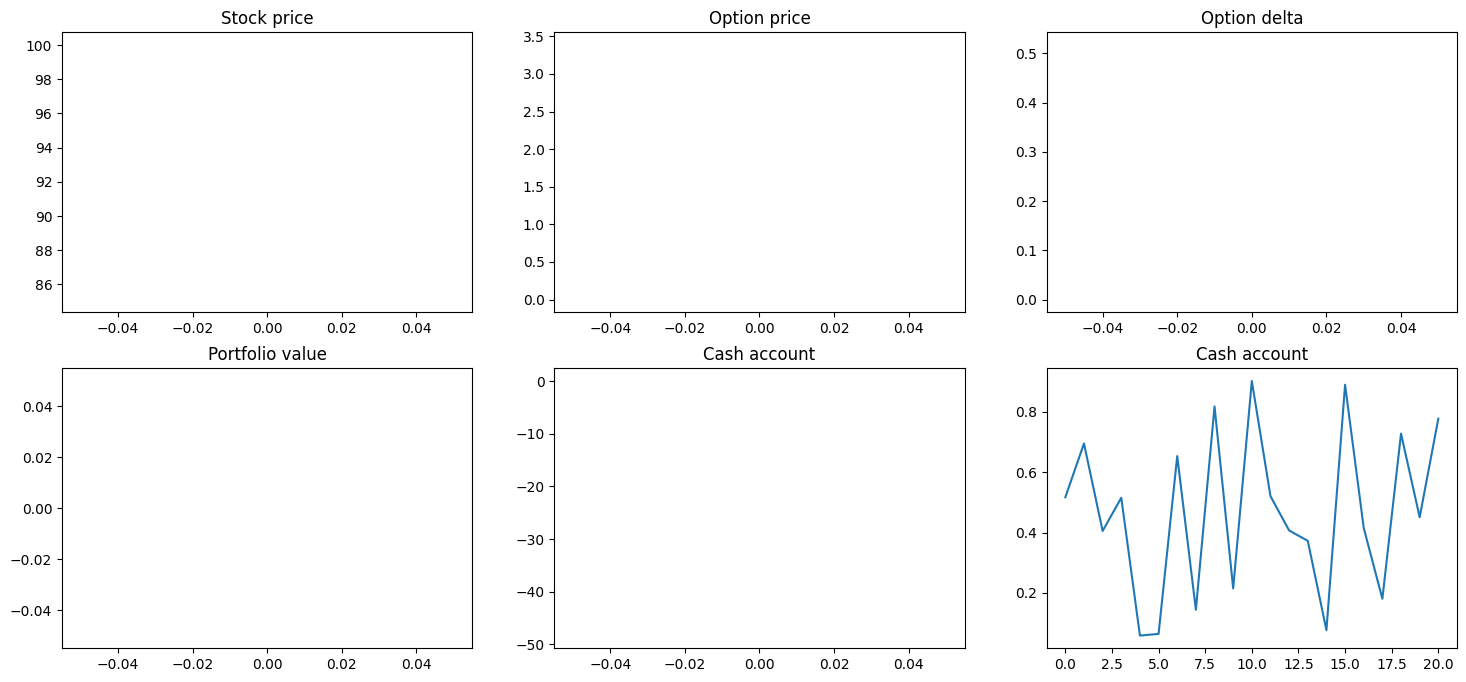

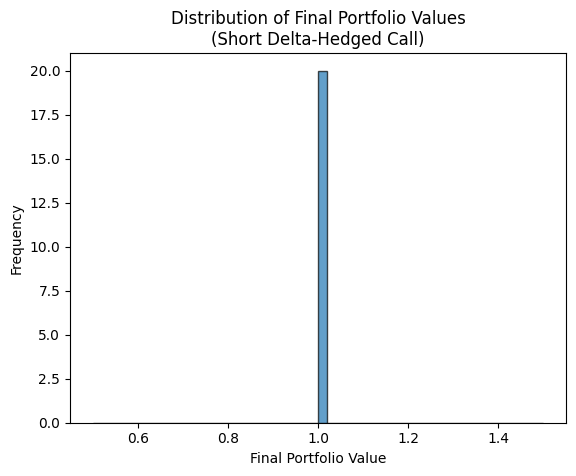

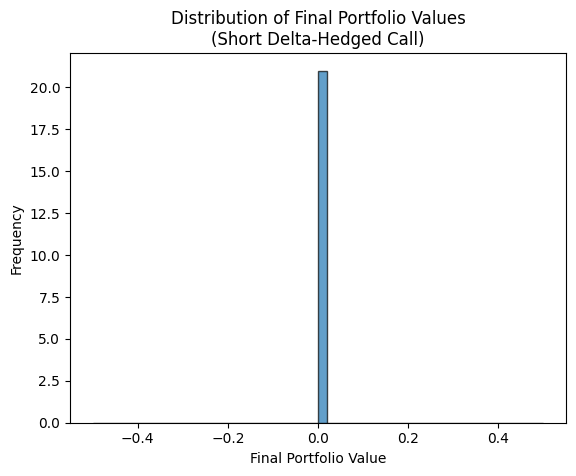

In [125]:
r =0.0
time_points = stock_prices.shape[0]
n_paths = stock_prices.shape[1]
df_stock = stock_prices
df_call = option_prices 
df_delta = deltas

df_cash = pd.DataFrame(np.zeros((time_points, n_paths)))
df_pnl = pd.DataFrame(np.zeros((time_points, n_paths)))

df_cash.iloc[0, :] = df_call.iloc[0, :] - df_delta.iloc[0, :] * df_stock.iloc[0, :]

df_pnl.iloc[0, :] = -df_call.iloc[0, :] + df_delta.iloc[0, :] * df_stock.iloc[0, :] + df_cash.iloc[0, :]

old_delta = df_delta.iloc[0, :].values  # store the previous delta

for t in range(1, time_points):

    new_delta = df_delta.iloc[t, :].values
   
    rebalancing_cost = (new_delta - old_delta) * df_stock.iloc[t, :].values

    df_cash.iloc[t, :] = df_cash.iloc[t-1, :].values*np.exp(r*1/time_points) - rebalancing_cost

    df_pnl.iloc[t, :] = -df_call.iloc[t, :] + new_delta * df_stock.iloc[t, :] + df_cash.iloc[t, :]
    old_delta = new_delta

fig, ax = plt.subplots(2, 3, figsize=(18, 8))

ax[0, 0].plot(stock_prices)
ax[0, 0].set_title('Stock price')

ax[0, 1].plot(option_prices)
ax[0, 1].set_title('Option price')

ax[0, 2].plot(deltas)
ax[0, 2].set_title('Option delta')

ax[1, 0].plot(df_pnl)
ax[1, 0].set_title('Portfolio value')

ax[1, 1].plot(df_cash)
ax[1, 1].set_title('Cash account')

ax[1, 2].plot(actions)
ax[1, 2].set_title('Cash account')

plt.show()



plt.hist(df_pnl.iloc[-1,:]/df_call.iloc[0,:] + 1, bins=50, edgecolor='k', alpha=0.7)
plt.xlabel("Final Portfolio Value")
plt.ylabel("Frequency")
plt.title("Distribution of Final Portfolio Values\n(Short Delta-Hedged Call)")
plt.show()
plt.hist(df_pnl.iloc[-1,:], bins=50, edgecolor='k', alpha=0.7)
plt.xlabel("Final Portfolio Value")
plt.ylabel("Frequency")
plt.title("Distribution of Final Portfolio Values\n(Short Delta-Hedged Call)")
plt.show()